In [1]:
import pandas as pd
import numpy as np
import os
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import random
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap

# load plot setting parameters
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({'font.size': 17.5})
# plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16
plt.rcParams['axes.labelpad'] = 10
plt.rcParams['axes.titlepad'] = 15

In [2]:
def process_files(CEMS_file,df860_file):

    df = pd.read_csv(f'C:/Users/surid/Downloads/{CEMS_file}.csv',
                low_memory=False)

    # filter where Primary Fuel Type is Pipeline Natural Gas or Natural Gas
    df = df[df['Primary Fuel Type'] == 'Coal']
    #df_cems_C = df_cems[df_cems['Primary Fuel Type'] == 'Coal']

    df['Date'] = pd.to_datetime(df['Date'])
    df['Hour'] = pd.to_timedelta(df['Hour'], unit='h')
    df['Datetime'] = df['Date'] + df['Hour']
    columns = ['Facility ID', 'Datetime', 'CO2 Mass (short tons)', 'Gross Load (MW)', 'Operating Time']
    df_mod = df[columns].copy()

    # Convert short tons to metric tons and calculate total energy produced
    df_mod['CO2 Mass (metric tons)'] = df_mod['CO2 Mass (short tons)'] * 0.907185
    df_mod['Generation (MWh)'] = df_mod['Gross Load (MW)'] * df_mod['Operating Time']

    # Drop unnecessary columns
    df_mod.drop(columns=['CO2 Mass (short tons)', 'Gross Load (MW)', 'Operating Time'], inplace=True)

    df_mod['Intensity (tons/MWh)'] = df_mod['CO2 Mass (metric tons)'] / df_mod['Generation (MWh)']
    # replace inf with na and drop
    df_mod.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_mod.dropna(inplace=True)

    df_mod = df_mod.groupby(['Datetime', 'Facility ID']).sum().reset_index()

    # create a plant metadata dataframe for the given year

    df_860 = pd.read_excel(f'C:/Users/surid/Downloads/{df860_file}.xlsx',
                        sheet_name='Operable',
                        skiprows=1)

    columns = ['Plant Code', 'Generator ID', 'Technology', 'Nameplate Capacity (MW)']
    df_860_mod = df_860[columns].copy()

    technologies = ['Petroleum Liquids', 'Natural Gas Steam Turbine',
        'Conventional Steam Coal', 'Natural Gas Fired Combined Cycle',
        'Natural Gas Fired Combustion Turbine',
        'Natural Gas Internal Combustion Engine',
        'Coal Integrated Gasification Combined Cycle', 'Other Gases',
        'Petroleum Coke',
        'Natural Gas with Compressed Air Storage',
        'Other Natural Gas']

    df_860_mod = df_860_mod[df_860_mod['Technology'].isin(technologies)]

    # sum the nameplate capacity for each plant
    # drop Generator ID and Technology columns
    df_860_mod.drop(columns=['Technology'], inplace=True)
    df_860_grouped = df_860_mod.groupby(['Plant Code'], as_index=False).sum()

    # generate unique plant and unit IDs
    #df_860_grouped['Plant Code'] = df_860_grouped['Plant Code'].astype(str)

    # same for df_mod
    #df_mod['Facility ID'] = df_mod['Facility ID'].astype(str)
    # rename to Plant Code
    df_mod.rename(columns={'Facility ID': 'Plant Code'}, inplace=True)

    # merge df_mod and df_860_grouped on Unit ID
    df_merged = pd.merge(df_mod, df_860_grouped, on='Plant Code', how='left')

    # merge df_mod and df_860_grouped
    #df_merged = pd.merge(df_mod, df_860_grouped, left_on='Facility ID', right_on='Plant Code', how='left')
    df_merged['cf'] = df_merged['Generation (MWh)'] / (df_merged['Nameplate Capacity (MW)'])

    return df_merged

In [3]:
df_filtered_2018 = process_files('emissions-hourly-2018-tx','3_1_Generator_Y2018')
df_filtered_2019 = process_files('emissions-hourly-2019-tx','3_1_Generator_Y2019')
df_filtered_2020 = process_files('emissions-hourly-2020-tx','3_1_Generator_Y2020')
df_filtered_2021 = process_files('emissions-hourly-2021-tx','3_1_Generator_Y2021')
df_filtered_2022 = process_files('emissions-hourly-2022-tx','3_1_Generator_Y2022')

In [4]:
df_filtered = pd.concat([df_filtered_2018, df_filtered_2019, df_filtered_2020, df_filtered_2021, df_filtered_2022])

In [5]:
# drop rows with cf = NaN
df_filtered.dropna(subset=['cf'], inplace=True)

In [7]:
num_plants = len(df_filtered['Plant Code'].unique())
num_plants

17

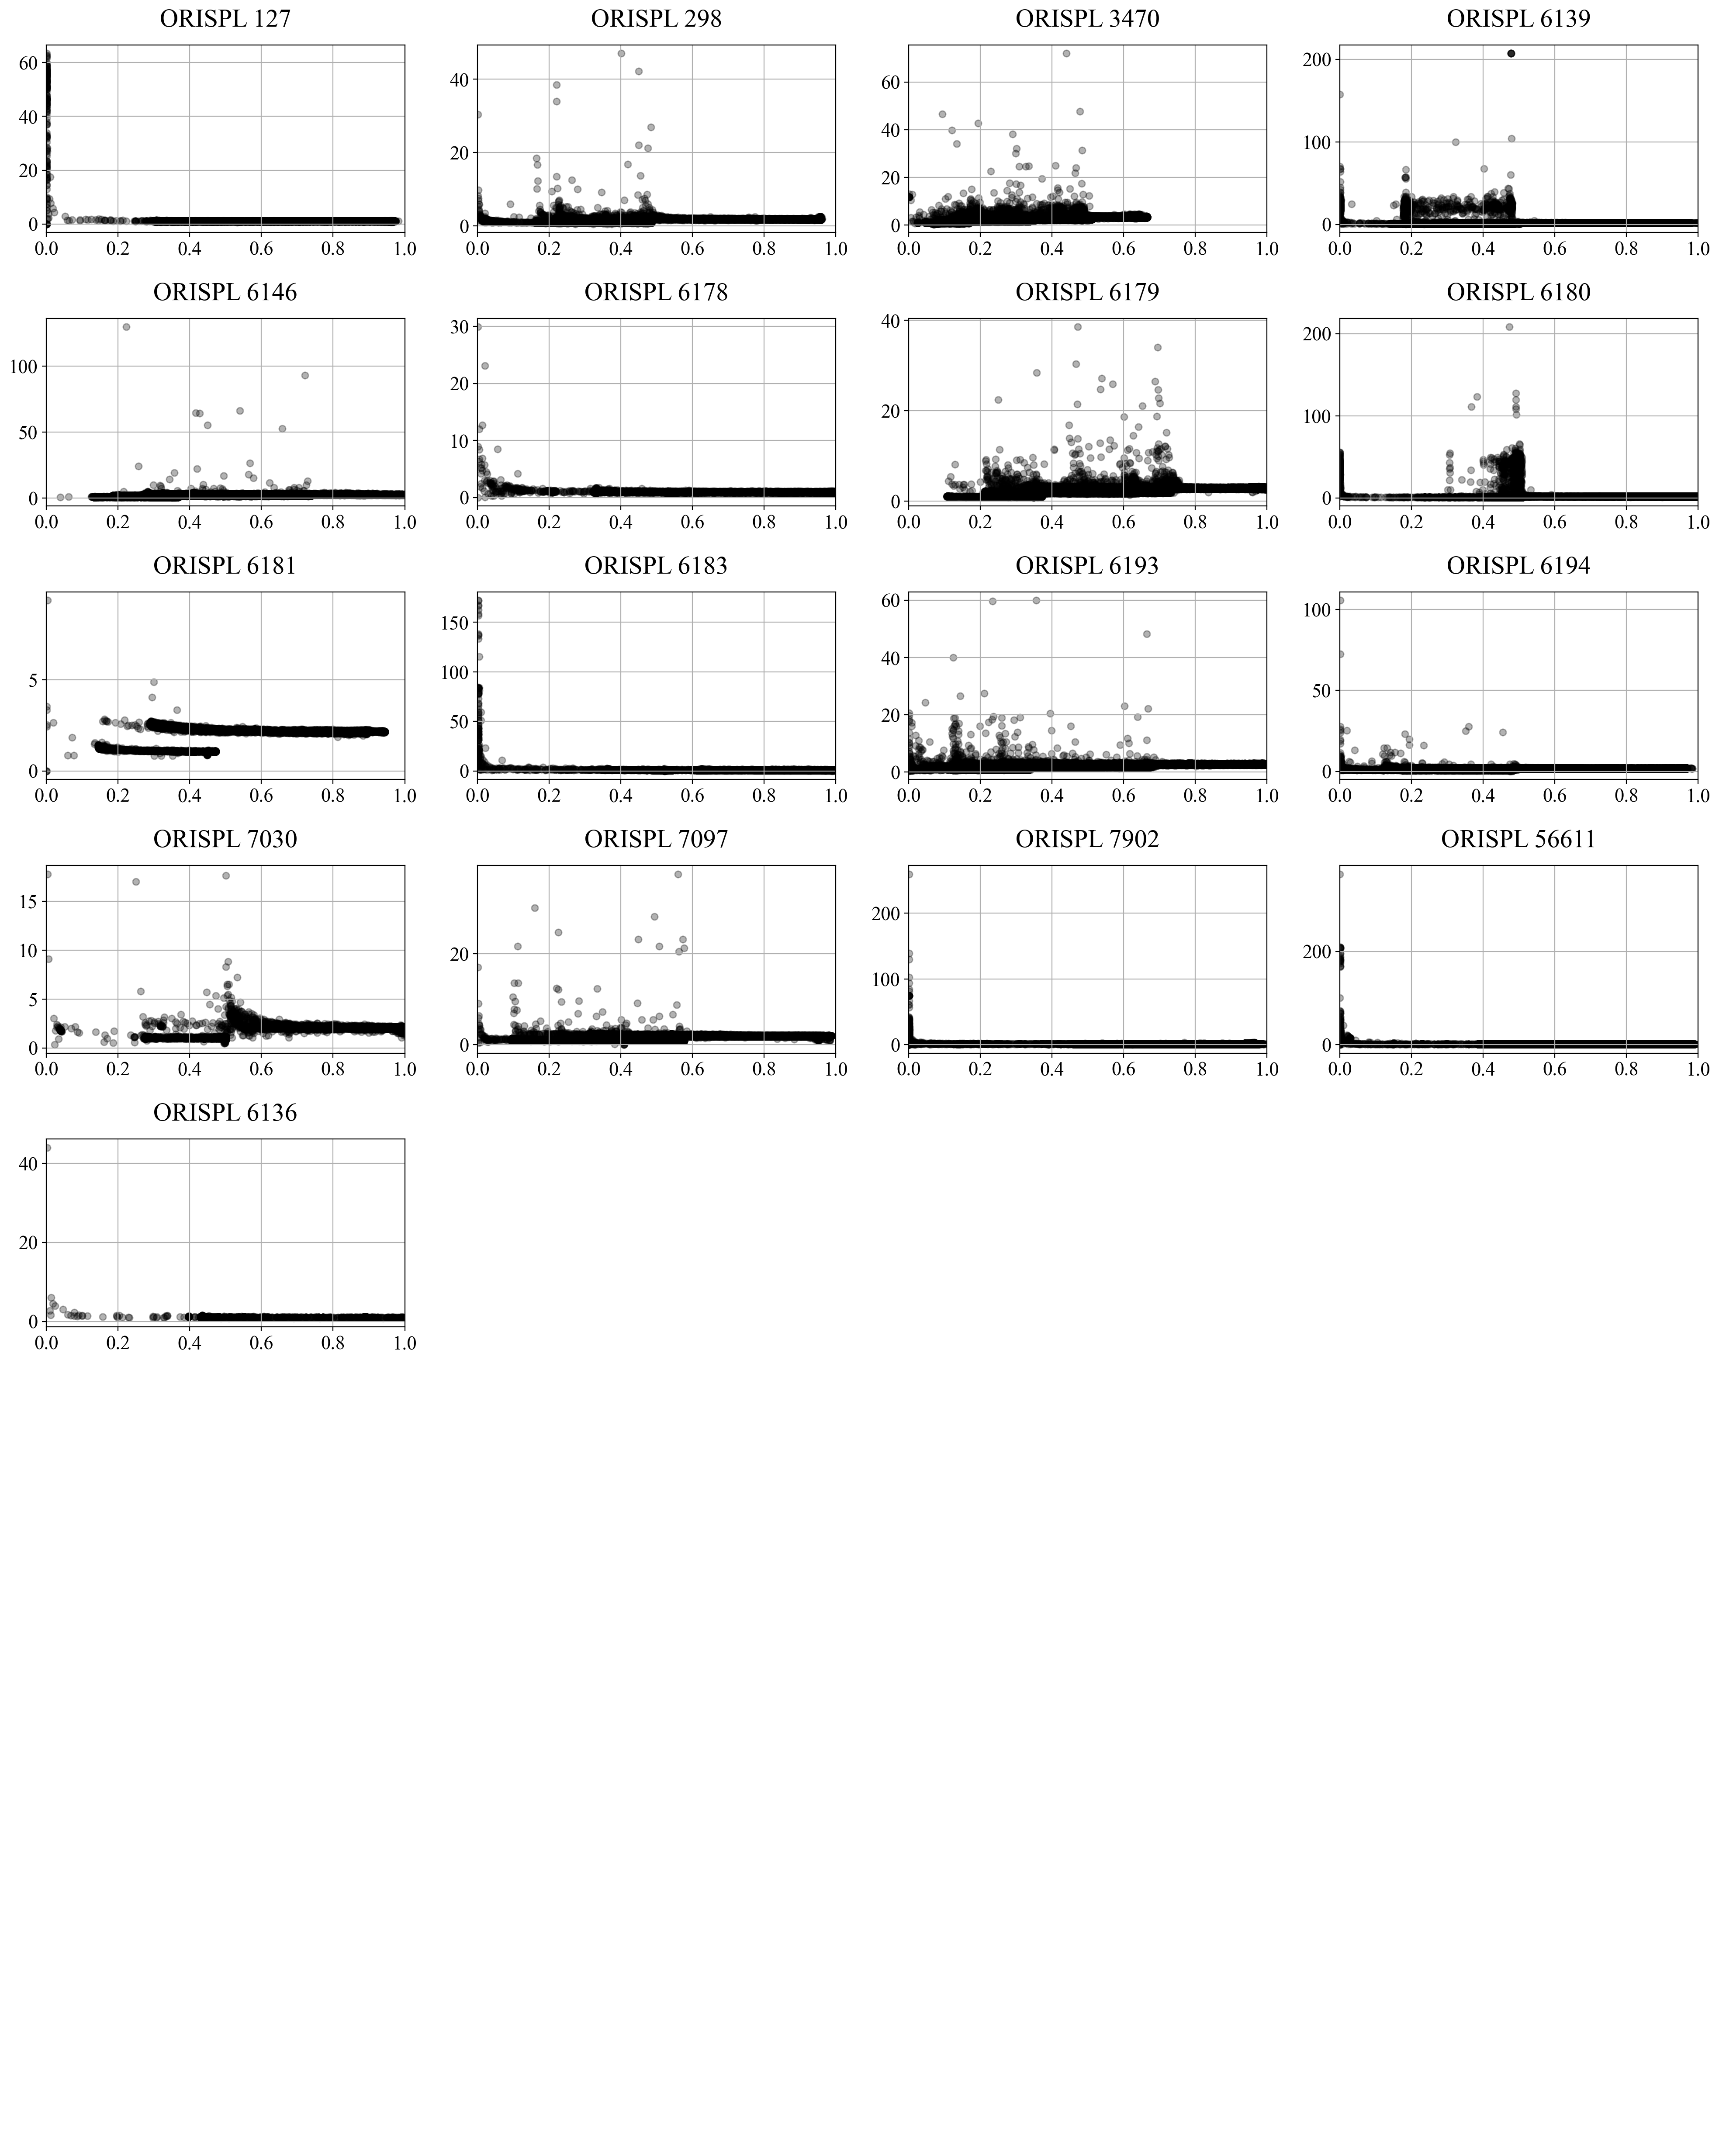

In [8]:
plants_per_figure = 8 * 4  # Number of subplots per figure
num_figures = -(-num_plants // plants_per_figure)  # Ceiling division to get the number of figures

# Plot each figure
for fig_idx in range(num_figures):
    start_idx = fig_idx * plants_per_figure
    end_idx = min((fig_idx + 1) * plants_per_figure, num_plants)
    
    # Create a new figure
    fig, axs = plt.subplots(8, 4, figsize=(20, 25), sharex=False, sharey=False, tight_layout=True)
    
    # Plot cf vs intensity, color scatter points by unit for each plant
    for i, ax in enumerate(axs.flat):
        plant_idx = start_idx + i
        if plant_idx >= num_plants:
            # Hide empty subplots in the last figure
            ax.axis('off')
            continue
        
        plant = df_filtered['Plant Code'].unique()[plant_idx]
        df_temp = df_filtered[df_filtered['Plant Code'] == plant]
        
    
        ax.scatter(df_temp['cf'], df_temp['Intensity (tons/MWh)'], s=30, color='black', alpha=0.3)
        
        ax.set_title(f'ORISPL {plant}')
        ax.set_xlim(0, 1)
        
        # Show grid
        ax.grid(True)
    
    plt.show()